In [56]:
# HW: https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/04-evaluation/homework.md
# Notes: https://github.com/DataTalksClub/machine-learning-zoomcamp/tree/master/04-evaluation
# https://www.youtube.com/watch?v=BIIZaVtUbf4&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=49

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('course_lead_scoring.csv')

In this dataset our desired target for classification task will be *converted* variable - has the client signed up to the platform or not.



**Data preparation**
Check if the missing values are presented in the features.
If there are missing values:
For caterogiral features, replace them with 'NA'
For numerical features, replace with with 0.0

In [58]:
# Data preparation. Check if the missing values are presented in the features.
df.isnull().sum()

,0
lead_source,128
industry,134
number_of_courses_viewed,0
annual_income,181
employment_status,100
location,63
interaction_count,0
lead_score,0
converted,0


In [59]:

mask = (df.dtypes.index != 'converted')

categorical = df.dtypes[(df.dtypes == 'object') & mask].index
categorical


numerical = df.dtypes[(df.dtypes != 'object') & mask].index

categorical, numerical

(Index(['lead_source', 'industry', 'employment_status', 'location'], dtype='object'),
 Index(['number_of_courses_viewed', 'annual_income', 'interaction_count',
        'lead_score'],
       dtype='object'))

In [60]:
#For caterogiral features, replace them with 'NA'
df_fill = df.copy()

for c in categorical:
  df_fill[c] = df_fill[c].fillna('NA')

#For numerical features, replace with with 0.0
for n in numerical:
  df_fill[n]  = df_fill[n].fillna(0.0)

In [61]:
# Data preparation. Check if the missing values are presented in the features.
df_fill.isnull().sum()

,0
lead_source,0
industry,0
number_of_courses_viewed,0
annual_income,0
employment_status,0
location,0
interaction_count,0
lead_score,0
converted,0


In [62]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution.
# Use train_test_split function for that with random_state=1
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df_fill, test_size=0.2, random_state=1)

print(df_full_train.shape)
print(df_test.shape)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(df_train.shape)
print(df_val.shape)
print(len(df_train) + len(df_val) + len(df_test) , len(df))

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

print(df_train.columns)
print(df_val.columns)
print(df_test.columns)

(1169, 9)
(293, 9)
(876, 9)
(293, 9)
1462 1462
Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score'],
      dtype='object')
Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score'],
      dtype='object')
Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score'],
      dtype='object')


In [63]:
print(df_train.head())
# print(df_val.head())
# print(df_test.head())

         lead_source       industry  number_of_courses_viewed  annual_income  \
462           events  manufacturing                         2        95543.0   
135         referral             NA                         1        54924.0   
117   organic_search     healthcare                         2        77352.0   
1051        paid_ads          other                         2        34600.0   
945         paid_ads      education                         0        43615.0   

     employment_status       location  interaction_count  lead_score  
462         unemployed         europe                  3        0.78  
135            student  south_america                  6        0.39  
117         unemployed         europe                  2        0.22  
1051          employed  south_america                  2        0.31  
945         unemployed  south_america                  2        0.01  


In [64]:
# Question 1: ROC AUC feature importance
# ROC AUC could also be used to evaluate feature importance of numerical variables.
# Let's do that
# For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
# Use the training dataset for that
# If your AUC is < 0.5, invert this variable by putting "-" in front
# (e.g. -df_train['balance'])
# AUC can go below 0.5 if the variable is negatively correlated with the target variable.
# You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.
# Which numerical variable (among the following 4) has the highest AUC?
# R=> number_of_courses_viewed
from sklearn.metrics import roc_auc_score

scores = []
for n in numerical:
  y_score = df_train[n].values
  roc_auc_score_ = roc_auc_score(y_train, y_score)
  print(n, roc_auc_score_)

  if(roc_auc_score_ < 0.5):
    df_train[n] = -df_train[n]

  scores.append(roc_auc_score_)

number_of_courses_viewed 0.7635680590007088
annual_income 0.5519578313253012
interaction_count 0.738270176293409
lead_score 0.6144993577250176


In [65]:
# Question 2: Training the model
# Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'));

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)

model.intercept_
model.coef_.round(3)

(876, 31) (876,)
(293, 31) (293,)


array([[-0.   , -0.027,  0.035, -0.01 ,  0.014, -0.117, -0.022,  0.033,
        -0.008, -0.023, -0.007, -0.033, -0.027, -0.018,  0.326,  0.032,
         0.   , -0.005, -0.024, -0.112,  0.07 , -0.034,  0.005, -0.012,
        -0.01 , -0.028, -0.013, -0.019, -0.023, -0.005,  0.453]])

In [66]:
# What's the AUC of this model on the validation dataset? (round to 3 digits)
# 0.32
# 0.52
# 0.72
# 0.92
# R => 0.72
y_pred = model.predict_proba(X_val)[:, 1]


score_val = roc_auc_score(y_val, y_pred)
print(score_val.round(3))
0.817 - 0.92 , 0.817 - 0.72

0.817


(-0.10300000000000009, 0.09699999999999998)

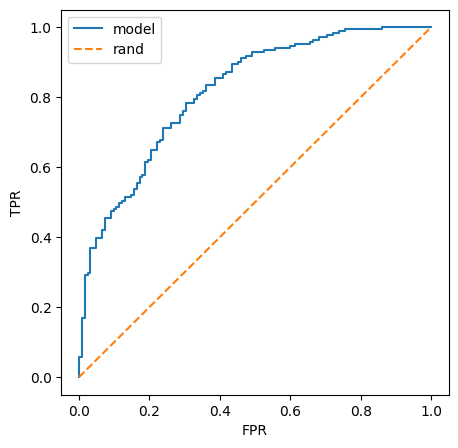

In [67]:
from sklearn.metrics import roc_curve

fpr, tpr, th = roc_curve(y_val, y_pred)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='rand', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [79]:
from sklearn.metrics import auc

auc_ = auc(fpr, tpr)

auc_

np.float64(0.8171316268814112)

In [68]:
0.72 - 0.817 ,  0.92 - 0.817

(-0.09699999999999998, 0.10300000000000009)

In [69]:
# Question 3: Precision and Recall
# Now let's compute precision and recall for our model.

# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
# For each threshold, compute precision and recall
# Plot them
# At which threshold precision and recall curves intersect?
# 0.145
# 0.345
# 0.545
# 0.745

# R => 0.745
thresholds = np.arange(0.0, 1.0, 0.01)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

scores_t = []
for t in thresholds:
  predic_positive = (y_pred >= t)
  predict_negative = (y_pred < t)

  tp = (predic_positive & actual_positive).sum()
  tn = (predict_negative & actual_negative).sum()

  fp = (predic_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()

  precision = tp/(tp + fp)
  recall = tp / (tp + fn)

  scores_t.append((t, tp, fp, fn, tn, precision, recall))
  #print(t, scores_t)

  #scores_t

/tmp/ipython-input-1253228411.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp + fp)


In [70]:
# (t, tp, fp, fn, tn, precision, recall))
columns = ['t', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores_t, columns=columns)
df_scores[ (df_scores.t > 0.6) & (df_scores.t<0.68) ]

,t,tp,fp,fn,tn,precision,recall
61,0.61,148,50,23,72,0.747475,0.865497
62,0.62,143,45,28,77,0.760638,0.836257
63,0.63,139,43,32,79,0.763736,0.812865
64,0.64,134,38,37,84,0.779070,0.783626
65,0.65,130,37,41,85,0.778443,0.760234
66,0.66,124,35,47,87,0.779874,0.725146
67,0.67,122,31,49,91,0.797386,0.713450


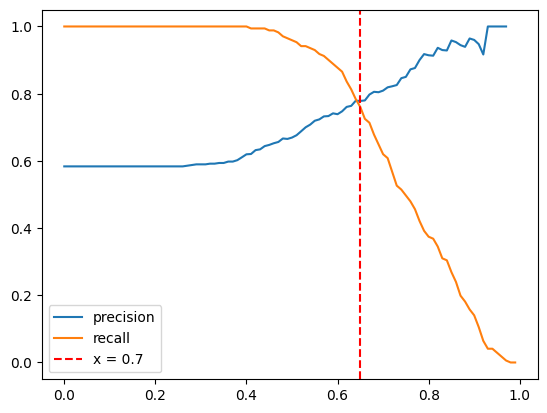

In [71]:
plt.plot(df_scores.t, df_scores.precision, label='precision')
plt.plot(df_scores.t, df_scores.recall, label='recall')
plt.axvline(x=0.65, color='red', linestyle='--', label='x = 0.7')
plt.legend()


In [72]:
0.545 - 0.65 , 0.745 - 0.65

(-0.10499999999999998, 0.09499999999999997)

In [73]:
# Question 4: F1 score
# Precision and recall are conflicting - when one grows, the other goes down.
# That's why they are often combined into the F1 score - a metrics that takes into account both
# This is the formula for computing F1 = 2*(precision*recall)/(precision+recall)
# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
# At which threshold F1 is maximal?
# 0.14
# 0.34
# 0.54
# 0.74

# R=> 0.74
f1 = 2 * ((df_scores.precision * df_scores.recall)/(df_scores.precision + df_scores.recall))
df_scores['f1']=f1

df_scores.f1.max()

0.8124999999999999

In [74]:
def train(df, y_train, c=1.0):
  dicts = df.to_dict(orient='records')

  dv = DictVectorizer(sparse=False)
  X_train = dv.fit_transform(dicts)

  model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
  model.fit(X_train, y_train)

  return dv, model

def predict(df, dv, model):
   dicts = df.to_dict(orient='records')
   X = dv.transform(dicts)
   y_pred = model.predict_proba(X)[:, 1]

   return y_pred

In [81]:
# Question 5: 5-Fold CV
# Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
# KFold(n_splits=5, shuffle=True, random_state=1)

# Iterate over different folds of df_full_train
# Split the data into train and validation

# Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# Use AUC to evaluate the model on validation
# How large is standard deviation of the scores across different folds?

# 0.0001
# 0.006
# 0.06
# 0.36
# R => 0.06
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)
scores_k = []

for train_idx, val_idx in kfold.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = df_train.converted.values
  y_val = df_val.converted.values

  dv, model = train(df_train, y_train, c=1.0)
  y_pred = predict(df_val, dv, model)

   # AUC
  auc = roc_auc_score(y_val, y_pred)
  scores_k.append(auc)

print('C=%s %.3f std %.3f' % (1.0, np.mean(scores_k), np.std(scores_k)))
0.0001 - 0.032 , 0.006  - 0.032 ,  0.06  - 0.032 ,  0.36  - 0.032

C=1.0 0.876 std 0.032


(-0.0319, -0.026000000000000002, 0.027999999999999997, 0.32799999999999996)

In [76]:
!pip install tqdm

In [83]:
# Question 6: Hyperparameter Tuning
# Now let's use 5-Fold cross-validation to find the best parameter C

# Iterate over the following C values: [0.000001, 0.001, 1]
# Initialize KFold with the same parameters as previously
# Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
# Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
# Which C leads to the best mean score?

# 0.000001
# 0.001
# 1
# If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.
# R => 0.001
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

k = 5

for c in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=k, shuffle=True, random_state=1)

    scores_kc = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        # training and predicting
        dv, model = train(df_train, y_train, c=c)
        y_pred = predict(df_val, dv, model)

        # AUC
        auc = roc_auc_score(y_val, y_pred)
        scores_kc.append(auc)

    print('C=%s %.3f  %.3f' % (c, np.mean(scores_kc), np.std(scores_kc)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.561  0.024
C=0.001 0.926  0.018
C=1 0.876  0.032
